In [1]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [142]:
nationalities=[
'German',
'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'West Indian',
'Filipino'
]

In [143]:
races =[ 
    'Christianity',
    'Islam',
    'Atheist',
    'Hinduism',
    'Buddhism',
    'Diasporic',
    'Sikhism',
    'Juche',
    'Judaism',
    'Bahai',
    'Jainism',
    'Shinto',
    'Zoroastrianism',
    'Paganism',
    'Universalism'
]

In [3]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [4]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [164]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        if word in embeddings:
            toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
            words.append(word)
    return zip(words,toxicities)

In [28]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [7]:
# embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/numberbatch.txt',)
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

## train new corpus toxicity classifier

In [19]:
pos_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,pos_words))
neg_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,neg_words))
pos_vectors = embeddings_debiased[pos_words_fil_debiased]
neg_vectors = embeddings_debiased[neg_words_fil_debiased]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model_debias = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model_debias.predict(test_vectors)
(preds == test_targets).mean()

0.9682034976152624

## train debiased news corpus toxicity classifier

In [21]:
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
(preds == test_targets).mean()

0.9477020602218701

## test toxicity on gender equalized vs non equalized

In [41]:
text_to_toxicity(model_debias,embeddings_debiased,'/c/en/'+'gay'),text_to_toxicity(model,embeddings,"gay")

(0.3588644596023533, 0.9744714403633258)

## create identity keyword toxicity histograms

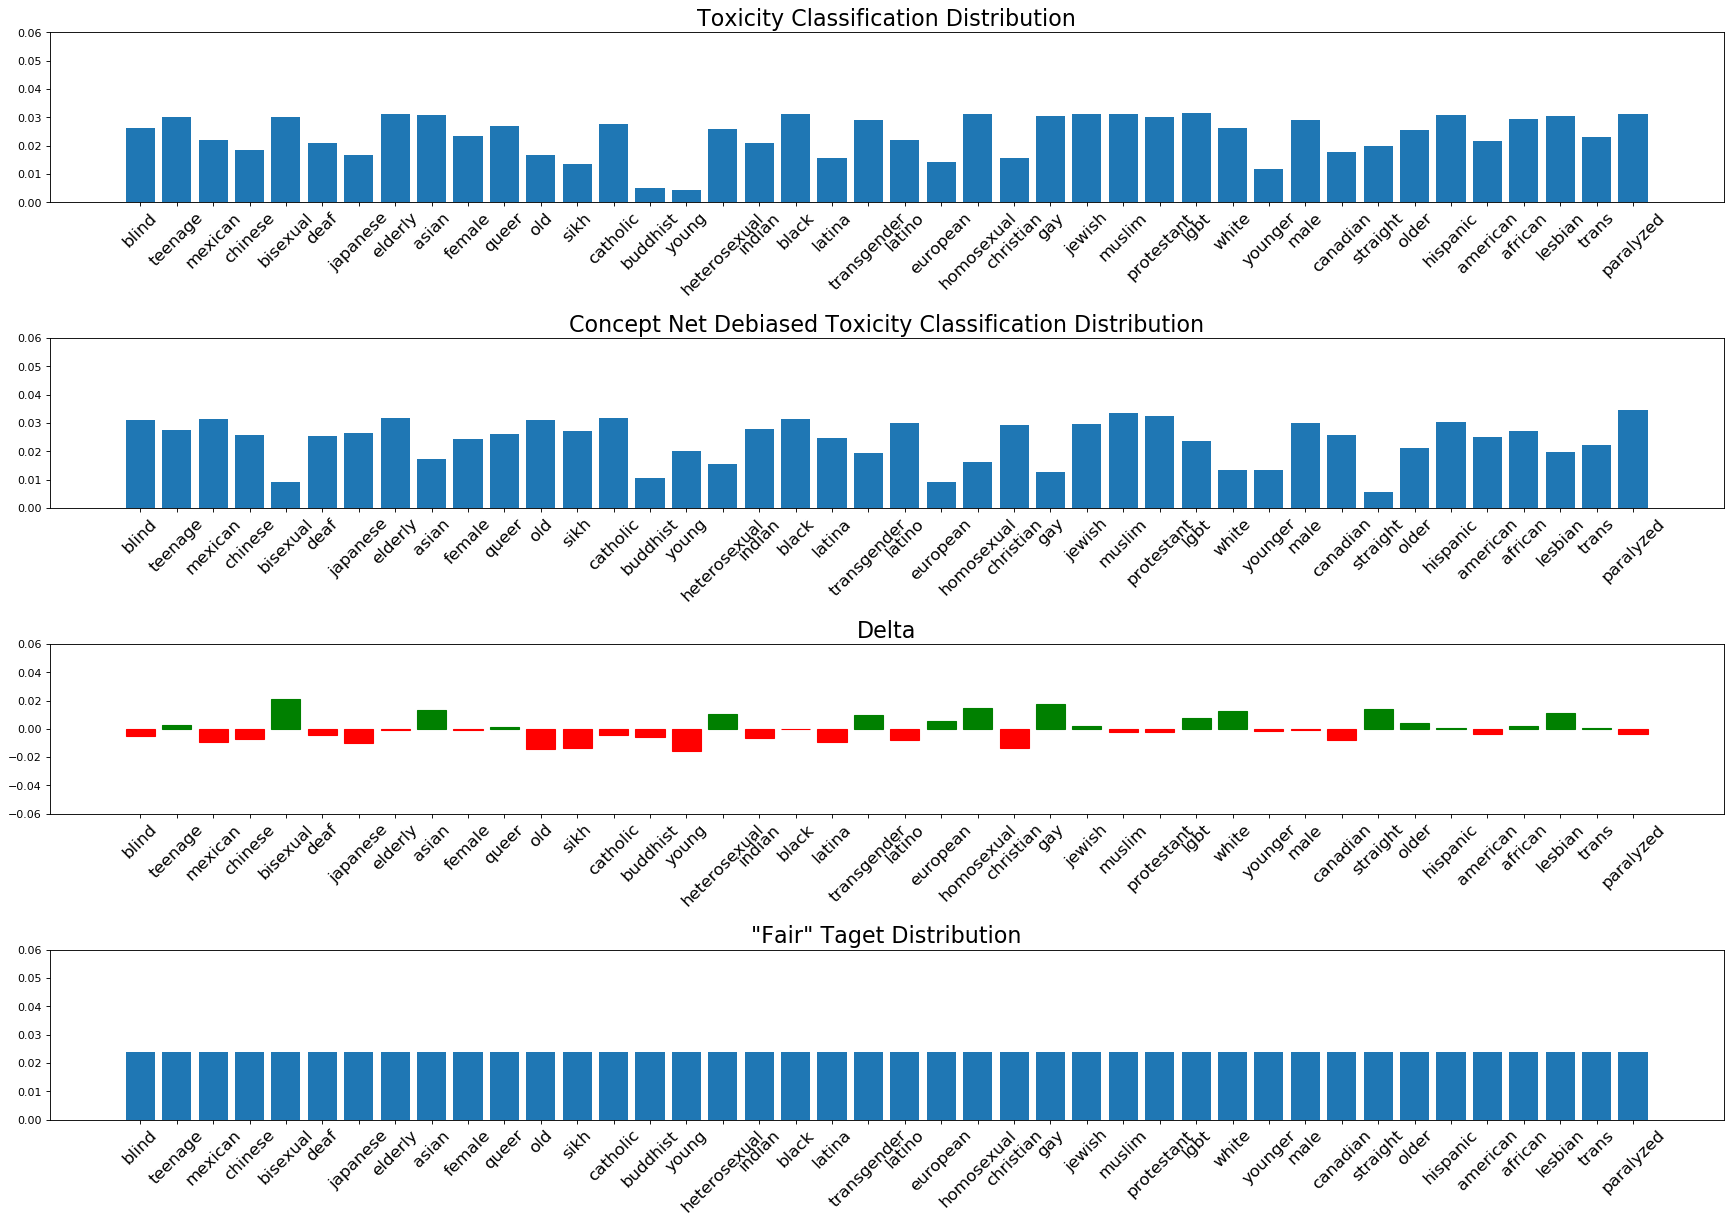

kl divergence from uniform dist for concept net: 0.05779202343063937
kl divergence from uniform dist for google news: 0.055767841113624254


In [171]:
identity_toxicity_debias = dict(identity_toxicity_table(identities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(identities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

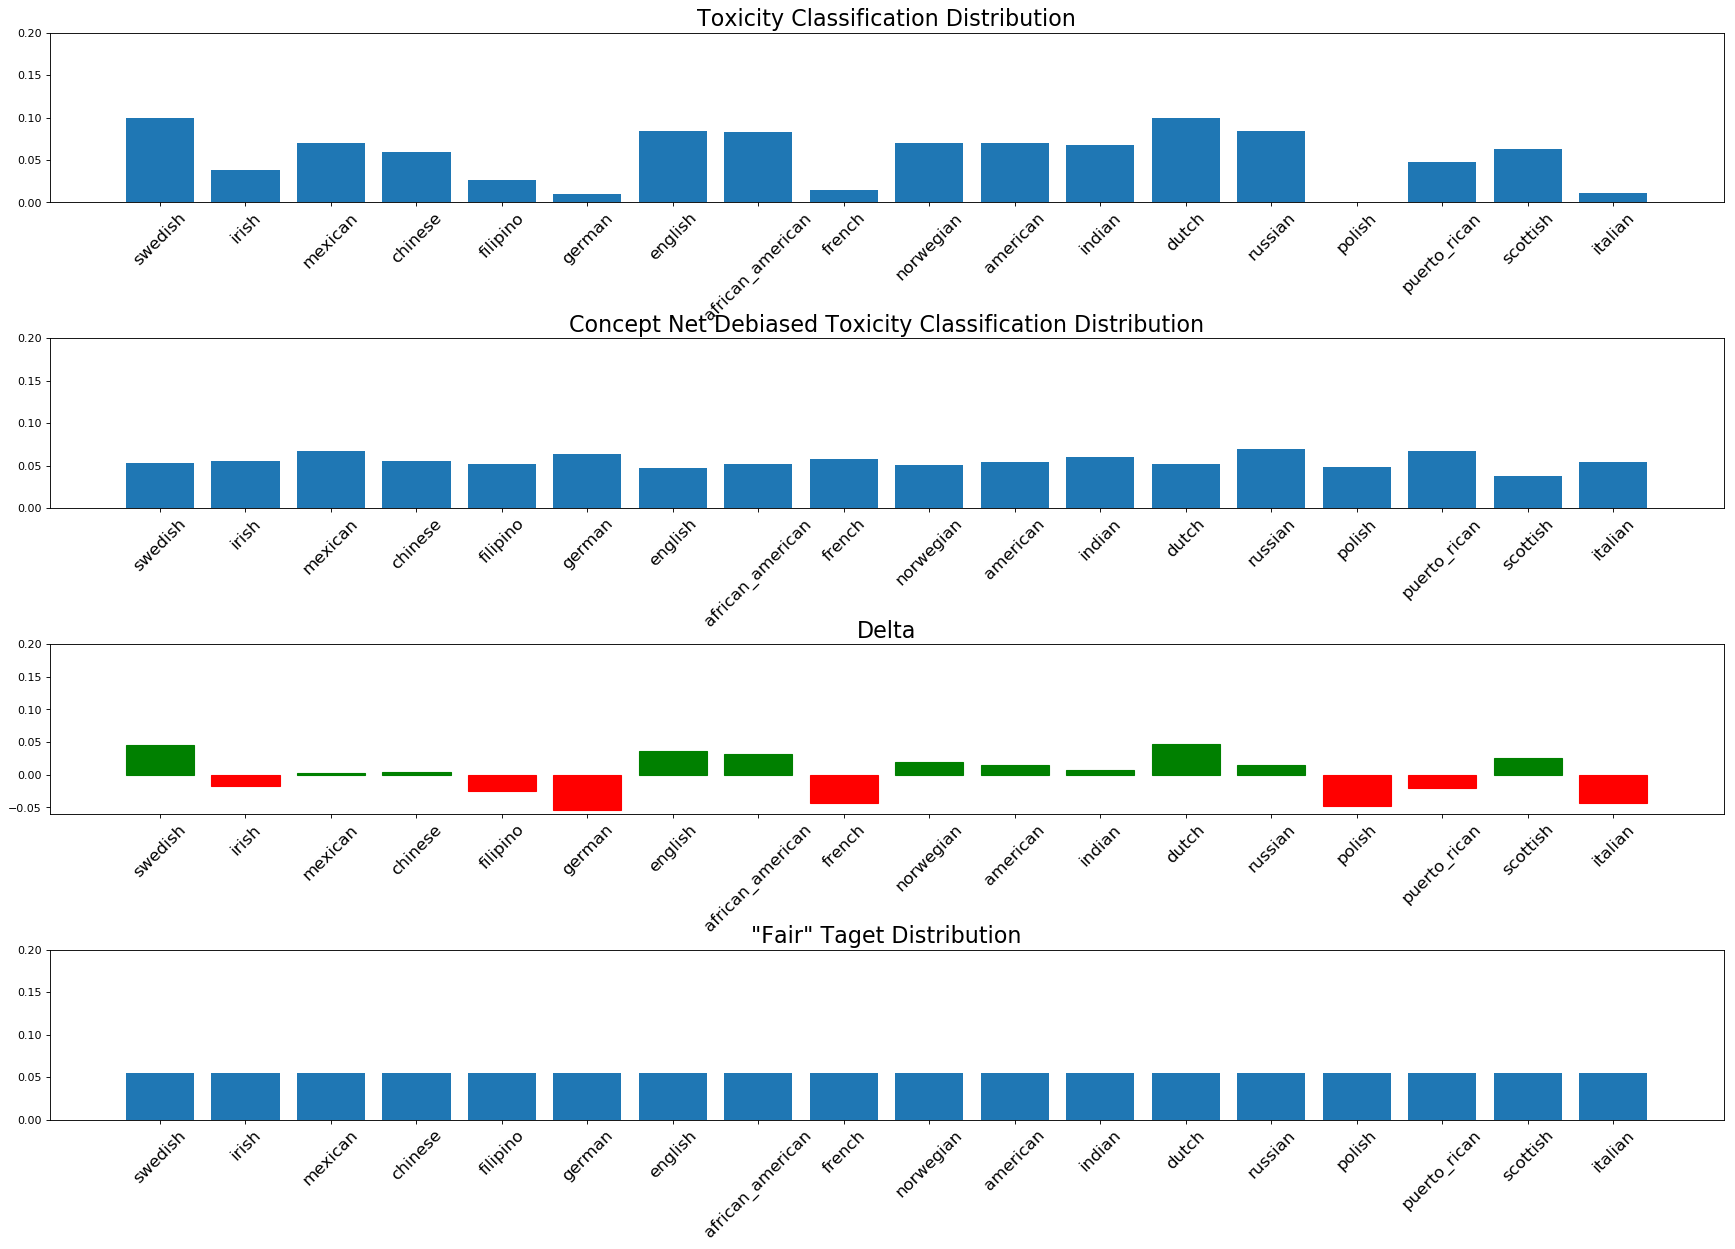

kl divergence from uniform dist for concept net: 0.010194184417816068
kl divergence from uniform dist for google news: 0.19450034674063088


In [172]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

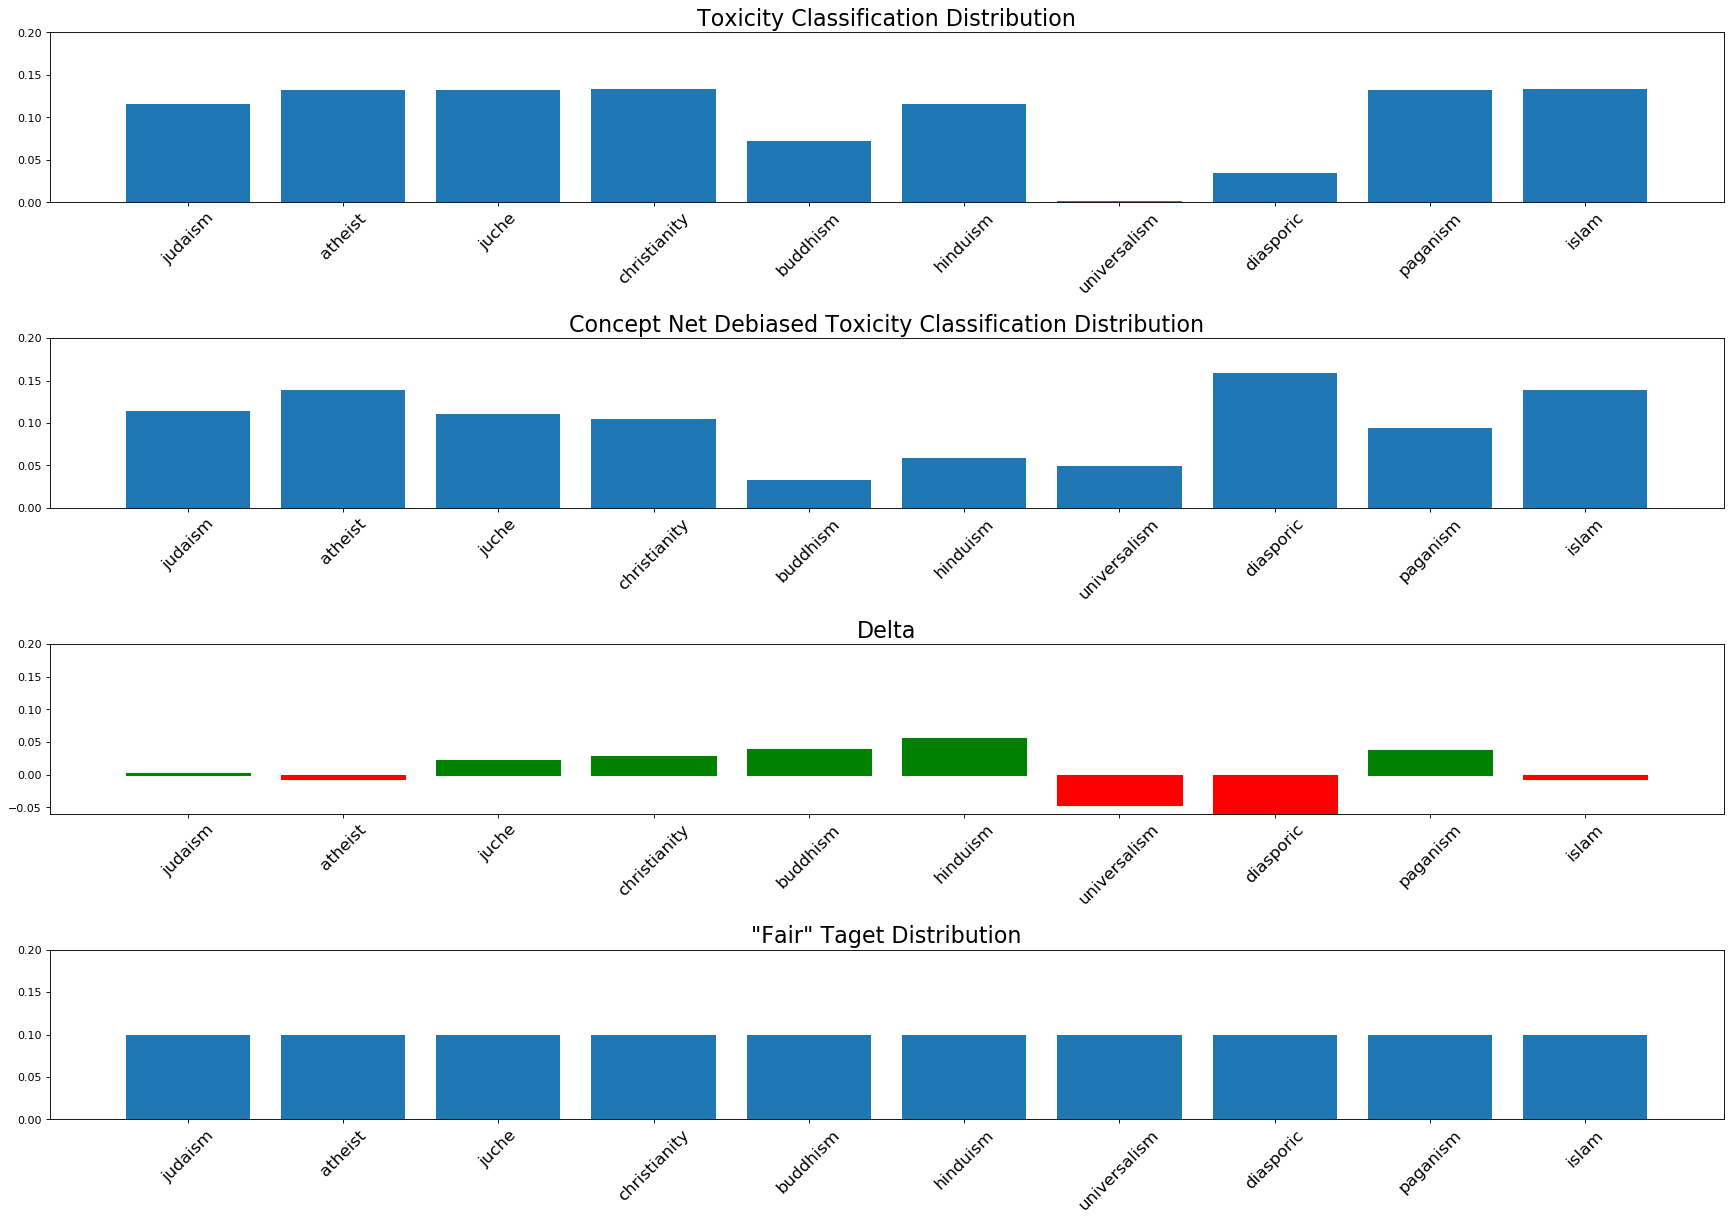

kl divergence from uniform dist for concept net: 0.0856863559174515
kl divergence from uniform dist for google news: 0.1503998601112115


In [173]:
identity_toxicity_debias = dict(identity_toxicity_table(races, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(races,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

## Toxicity Variance in histogram debiased vs non debiased

In [107]:
np.var(identity_toxicity_debias[1]),np.var(identity_toxicity[1])

(0.04579002936934977, 0.05427756124016946)

## KL Divergence from uniform dist

In [170]:
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

kl divergence from uniform dist for concept net: 0.0856863559174515
kl divergence from uniform dist for google news: 0.1503998601112115
